In [1]:
# import helper
import pandas as pd
from utils import *

import time
import numpy as np
import math
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torch import nn

from IPython.display import Image

import torch
from torch import nn
from torch.utils.data import Dataset
import pennylane as qml
import torch.optim as optim
import torch.utils.data as data
import random
import tensorflow as tf

In [91]:
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams.update({'font.size':20})
legend_prop = {'weight':'bold'}
from pylab import rcParams
rcParams['axes.linewidth'] = 2

## Brief Outline

The notebook will proceed in the following manner:

1. Brief description of Data
2. Using Classical LSTM to perform stock price prediction
3. Using classical ARIMA to perform stock price prediction
4. Using Multiple linear regression to perform stock price prediction 

## 1. Data

First, we read in the data, dropping the index and the date.

In [2]:
df = pd.read_csv('dataset_FTSE_prediction_v1.csv')
df = df.drop([ 'Unnamed: 0'], axis=1)
df=df.drop(columns=['ARIMA'])

We identify the dependent and independent variables:

In [3]:
target = "Close"

In [4]:
features = list(df.columns.difference(["Close"]))
features

['Adj Close',
 'BBB_20_2.0',
 'BBL_20_2.0',
 'BBM_20_2.0',
 'BBP_20_2.0',
 'BBU_20_2.0',
 'CUMLOGRET_1',
 'Close_copy',
 'Crude Futures',
 'EMA_10',
 'EMA_20',
 'EMA_50',
 'FT3',
 'FT6',
 'FT9',
 'GBP USD ',
 'Gold in USD',
 'MACD_12_26_9',
 'MACDh_12_26_9',
 'MACDs_12_26_9',
 'SMA_10',
 'SMA_20',
 'SMA_50',
 'Volume']

## Data processing for time series model

To process the data, we first define few terms

In [5]:
sequence_length = window= 10 # Number of time steps that will be inputted into LSTM network and Number of Predicting days 
batch_size=16 # Number of training instances in the batch
torch.manual_seed(42)
random.seed(42)

Next, in order to ensure that some values due to their mangnitude do not inherently dominate the features, we standardize their values.

In [6]:
target_mean = df[target].mean()
target_stdev = df[target].std()

for c in df.columns:
    mean = df[c].mean()
    stdev = df[c].std()

    df[c] = (df[c] - mean) / stdev

In [7]:
df

,Adj Close,BBB_20_2.0,BBL_20_2.0,BBM_20_2.0,BBP_20_2.0,BBU_20_2.0,CUMLOGRET_1,Close,Crude Futures,EMA_10,...,GBP USD,Gold in USD,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,SMA_10,SMA_20,SMA_50,Volume,Close_copy
0,-2.117565,-1.416161,-7.846089,-8.197548,-1.587882,-8.374291,-2.243124,-2.117565,1.500541,-9.214615,...,1.529613,1.234563,-0.077292,0.000882,-0.083523,-9.189175,-8.197548,-6.432481,0.730166,-2.117565
1,-2.312586,-1.416161,-7.846089,-8.197548,-1.587882,-8.374291,-2.482745,-2.312586,1.423609,-9.214615,...,1.462366,1.411190,-0.077292,0.000882,-0.083523,-9.189175,-8.197548,-6.432481,0.160281,-2.312586
2,-2.604116,-1.416161,-7.846089,-8.197548,-1.587882,-8.374291,-2.851864,-2.604116,1.423609,-9.214615,...,1.462366,1.411190,-0.077292,0.000882,-0.083523,-9.189175,-8.197548,-6.432481,0.028158,-2.604116
3,-2.520689,-1.416161,-7.846089,-8.197548,-1.587882,-8.374291,-2.744853,-2.520689,1.445590,-9.214615,...,1.395119,1.397119,-0.077292,0.000882,-0.083523,-9.189175,-8.197548,-6.432481,0.619960,-2.520689
4,-2.271642,-1.416161,-7.846089,-8.197548,-1.587882,-8.374291,-2.431965,-2.271642,1.559810,-9.214615,...,1.260624,1.190869,-0.077292,0.000882,-0.083523,-9.189175,-8.197548,-6.432481,0.212893,-2.271642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3134,0.972282,-0.117595,0.764524,0.780643,0.142467,0.779948,0.948611,0.972282,0.570682,0.879767,...,-0.958536,1.575597,-0.350816,0.702786,-0.631190,0.868999,0.780643,0.749319,-1.251617,0.972282
3135,0.996293,-0.303076,0.786476,0.769910,0.407189,0.736435,0.969864,0.996293,0.543992,0.884342,...,-1.025783,1.573375,-0.305387,0.671263,-0.570851,0.883658,0.769910,0.748743,-1.223489,0.996293
3136,1.052475,-0.347235,0.791464,0.767120,0.805365,0.725847,1.019417,1.052475,0.572645,0.897109,...,-1.025783,1.576708,-0.221191,0.738941,-0.504421,0.902589,0.767120,0.747719,-0.489123,1.052475
3137,1.081259,-0.357591,0.792661,0.766495,1.003170,0.723395,1.044711,1.081259,0.572252,0.912179,...,-1.025783,1.594852,-0.130016,0.809806,-0.431612,0.924056,0.766495,0.747135,-0.800152,1.081259


The last step in the data processing is to prepare the data in a sequence of past observations. Preparation of the time series data means that it uses a certain number of past observations to predict the future. In this case, the sequence length decides how many days the LSTM considers in advance and window decides how many days we want to predict for. If the sequence length is $n$ and window is $w$, then the LSTM considers the last $n$ observations to predict the next $w$ day price.

In [8]:
def create_dataset(dataset,target,features, lookback, window):
    X_store, y_store = [], []
    for i in range(len(dataset)-lookback-window):
        X = (dataset[features].values)[i:i+lookback]
        y = (dataset[target].values)[i+lookback-1:i+lookback+window-1]
        X_store.append(X)
        y_store.append(y)
    return torch.FloatTensor(np.array(X_store)), torch.FloatTensor(np.array(y_store))

X_ts, y_ts = create_dataset(
    df,
    target=target,
    features=features,
    lookback=sequence_length, window=window)

print(X_ts.shape, y_ts.shape)

torch.Size([3119, 10, 24]) torch.Size([3119, 10])


In [9]:
indices = tf.range(start=0, limit=tf.shape(X_ts)[0])
shuffled_indices = tf.random.shuffle(indices)

In [10]:
X_ts = tf.gather(X_ts, shuffled_indices)
y_ts = tf.gather(y_ts, shuffled_indices)
print(X_ts.shape, y_ts.shape)
X_ts=torch.FloatTensor(np.array(X_ts))
y_ts=torch.FloatTensor(np.array(y_ts))
print(X_ts.shape, y_ts.shape)

(3119, 10, 24) (3119, 10)
torch.Size([3119, 10, 24]) torch.Size([3119, 10])


In [11]:
# Train test split
n=X_ts.shape[0] # get first dimension
size=int(n*0.9)
X_train_ts=X_ts[:size]
y_train_ts=y_ts[:size]
X_test_ts=X_ts[size:]
y_test_ts=y_ts[size:]
print('Shape of train is',X_train_ts.shape,'and',y_train_ts.shape)
print('Shape os test is',X_test_ts.shape,'and',y_test_ts.shape)

Shape of train is torch.Size([2807, 10, 24]) and torch.Size([2807, 10])
Shape os test is torch.Size([312, 10, 24]) and torch.Size([312, 10])


In [12]:
train_loader = DataLoader(data.TensorDataset(X_train_ts, y_train_ts), shuffle=True, batch_size=batch_size)
test_loader= DataLoader(data.TensorDataset(X_test_ts, y_test_ts), shuffle=True, batch_size=batch_size)

In [13]:
# The unknown data
X_check=(df[features].values)[len(df)-window-sequence_length+1:len(df)- window+1]
y_check=(df[target].values)[len(df)-window:len(df)]
torch.FloatTensor([X_check]).shape

<ipython-input-13-65eb19419169>:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  torch.FloatTensor([X_check]).shape


torch.Size([1, 10, 24])

In [14]:
X_check

array([[ 0.79388494,  0.11492139,  0.9271362 ,  0.99339423, -1.827603  ,
         1.03871918,  0.78929789,  0.79388494,  0.31633506,  0.93808485,
         0.91886577,  0.82118453, -0.31462227, -0.26713774, -0.06299376,
        -0.89128884,  1.44969963, -0.69458969, -1.62274847, -0.16465527,
         0.97347243,  0.99339423,  0.79575778, -1.2886136 ],
       [ 0.72030983,  0.34272636,  0.86341434,  0.96904803, -1.764907  ,
         1.05467601,  0.72285648,  0.72030983,  0.34302582,  0.88772553,
         0.89009587,  0.81046173, -0.3220074 , -0.28023606, -0.0828843 ,
        -0.82404156,  1.45710536, -0.92417061, -1.84815061, -0.3310802 ,
         0.93251823,  0.96904803,  0.78999309, -0.78794397],
       [ 0.71322938,  0.50520554,  0.81036512,  0.9435188 , -1.53858648,
         1.05750005,  0.71643948,  0.71322938,  0.32968044,  0.84538512,
         0.86353232,  0.79998548, -0.32939134, -0.29334268, -0.10280674,
        -0.89128884,  1.48376599, -1.1001885 , -1.90012309, -0.502183  ,
  

In [15]:
y_check

array([1.04554877, 0.99229147, 1.03138787, 1.0133789 , 0.9904444 ,
       0.97228151, 0.99629347, 1.0524753 , 1.08125887, 1.08125887])

In [16]:
# for X, y in train_loader:
#     print(X)
#     print(y)

## Classical LSTM

We first define train_model: function to train the model based on the batches of data
We print the loss at the end to understand how the model is performing with regards to the data.

In [17]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()
    
    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")
    return avg_loss

def test_model(data_loader, model, loss_function):
    
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")
    return avg_loss

## Running the Classical LSTM

In the following code, we train LSTM to predict future stock prices, and then test it on the test dataset. 

In [18]:
class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 2

        self.lstm = nn.LSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1) # The output dimesion is set as window

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        
        out_, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(out_)
        return torch.squeeze(out)

In [19]:
learning_rate = 0.005
num_hidden_units = 200

model_lstm = ShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=learning_rate)

In [20]:
lstm_loss_train = []
lstm_loss_test=[]
num_epoch=150
for ix_epoch in range(num_epoch):
    print(f"Epoch {ix_epoch}\n---------")
    train_loss = train_model(train_loader, model_lstm, loss_function, optimizer=optimizer)
    test_loss = test_model(test_loader, model_lstm, loss_function)
    lstm_loss_train.append(train_loss)
    lstm_loss_test.append(test_loss)

Epoch 0
---------
Train loss: 0.0919897045453333
Test loss: 0.05683253118768335
Epoch 1
---------
Train loss: 0.05633831989358772
Test loss: 0.05286929188296199
Epoch 2
---------
Train loss: 0.05138774074360051
Test loss: 0.03534358227625489
Epoch 3
---------
Train loss: 0.03978060795502229
Test loss: 0.032307722605764866
Epoch 4
---------
Train loss: 0.033690230465832756
Test loss: 0.0388983610086143
Epoch 5
---------
Train loss: 0.030561402154324405
Test loss: 0.02771311402320862
Epoch 6
---------
Train loss: 0.027002666134979914
Test loss: 0.02450331919826567
Epoch 7
---------
Train loss: 0.023111863194075835
Test loss: 0.018545725010335447
Epoch 8
---------
Train loss: 0.019576949220870367
Test loss: 0.017691591568291188
Epoch 9
---------
Train loss: 0.016460452038286763
Test loss: 0.015620964230038226
Epoch 10
---------
Train loss: 0.014825827722564678
Test loss: 0.015834626788273454
Epoch 11
---------
Train loss: 0.013717368843076243
Test loss: 0.012360806344076991
Epoch 12
-----

Train loss: 0.0006480724679766519
Test loss: 0.002682593834470026
Epoch 98
---------
Train loss: 0.0006209093837903558
Test loss: 0.0027481953176902605
Epoch 99
---------
Train loss: 0.0006693369242301825
Test loss: 0.003277149907080457
Epoch 100
---------
Train loss: 0.0012446210045957494
Test loss: 0.0029866340395528824
Epoch 101
---------
Train loss: 0.0008393071746633558
Test loss: 0.0031691290787421167
Epoch 102
---------
Train loss: 0.0008087692666859683
Test loss: 0.0026438813598360865
Epoch 103
---------
Train loss: 0.0018905827374427727
Test loss: 0.008259277453180402
Epoch 104
---------
Train loss: 0.002147214566569098
Test loss: 0.003671091212891042
Epoch 105
---------
Train loss: 0.0007073696704703087
Test loss: 0.0027151724498253316
Epoch 106
---------
Train loss: 0.00048451290438771883
Test loss: 0.0027433455747086556
Epoch 107
---------
Train loss: 0.0004537682871159632
Test loss: 0.0025358599348692225
Epoch 108
---------
Train loss: 0.00041313167672673114
Test loss: 0.0

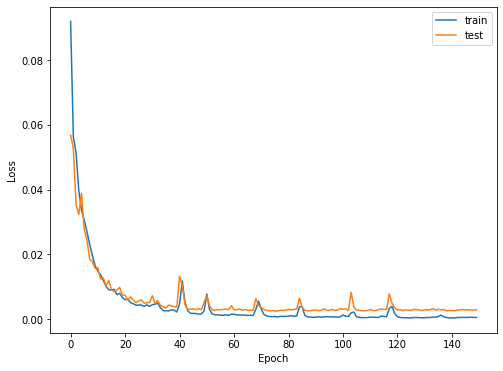

In [21]:
plt.figure(figsize=(8, 6))
plt.plot(range(num_epoch), lstm_loss_train, label='train')
plt.plot(range(num_epoch), lstm_loss_test, label='test')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

We then use the model to predict the test set, and then compare the results of the prediction to the real values.

In [22]:
def predict(data_loader, model):
    """Just like `test_loop` function but keep track of the outputs instead of the loss
    function.
    """
    output = []
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output.append(y_star.numpy())  
    return output

In [23]:
# Prepare data to evaluate training accuracy of lstm
train_eval_loader = DataLoader(data.TensorDataset(X_train_ts, y_train_ts), shuffle=False, batch_size=batch_size)
y_train_pred_lstm=predict(train_eval_loader, model_lstm)
y_train_lstm=[]
for X, y in train_eval_loader:
    y_train_lstm.append(y)
# Prepare data to evaluate test accuracy of lstm
test_eval_loader = DataLoader(data.TensorDataset(X_test_ts, y_test_ts), shuffle=False, batch_size=batch_size)
y_test_pred_lstm=predict(test_eval_loader, model_lstm)
y_test_lstm=[]
for X, y in test_eval_loader:
    y_test_lstm.append(y)

In [24]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
def cal_metrics(y_true,y_pred):
    mae=0
    rmse=0
    for i in range(len(y_true)):
        y1=y_true[i].flatten().numpy()* target_stdev + target_mean
        y2=y_pred[i].flatten()* target_stdev + target_mean
        mae=mean_absolute_error(y1, y2)+mae
        rmse=mean_squared_error(y1, y2, squared=False)+rmse  
    return mae/len(y_true) , rmse/len(y_true)

In [25]:
mae_train_lstm, rmse_train_lstm= cal_metrics(y_train_lstm,y_train_pred_lstm)
print('MAE train error is',mae_train_lstm)
print('RMSE train error is',rmse_train_lstm)
mae_test_lstm, rmse_test_lstm= cal_metrics(y_test_lstm,y_test_pred_lstm)
print('MAE test error is',mae_test_lstm)
print('RMSE test error is',rmse_test_lstm)

MAE train error is 9.571815729141235
RMSE train error is 15.383524585853923
MAE test error is 18.161194801330566
RMSE test error is 34.056847190856935


In [26]:
y_check_pred_lstm = model_lstm(torch.FloatTensor([X_check]))
y_check_pred_lstm = y_check_pred_lstm.detach().numpy()

mae_check_lstm = mean_absolute_error(y_check* target_stdev + target_mean,y_check_pred_lstm* target_stdev + target_mean)
print('MAE check error  : ',mae_check_lstm)
rmse_check_lstm = mean_squared_error(y_check* target_stdev + target_mean,y_check_pred_lstm* target_stdev + target_mean, squared=False)
print('RMSE check error : ',rmse_check_lstm)

MAE check error  :  22.073339843749817
RMSE check error :  29.498719661310094


## Running the ARIMA 

In [27]:
from statsmodels.tsa.arima.model import ARIMA
from pandas import DataFrame
from pandas import datetime

<ipython-input-27-c2c42f0d7345>:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [28]:
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from pmdarima.arima import auto_arima
train_data_arima=df[target].values[:len(df)-window] # train on full data
check_data_arima=df[target].values[len(df)-window:]

<ipython-input-28-de4a1ff72067>:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [29]:
print(check_data_arima)

[1.04554877 0.99229147 1.03138787 1.0133789  0.9904444  0.97228151
 0.99629347 1.0524753  1.08125887 1.08125887]


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8880.184, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=4907.180, Time=0.35 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-5685.308, Time=0.23 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-5693.845, Time=1.22 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.34 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-5689.003, Time=1.89 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-5683.446, Time=0.60 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-5684.169, Time=0.37 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.33 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-5685.012, Time=2.44 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-5691.881, Time=3.25 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0]          
Total fit time: 11.280 seconds
                               SARIMAX Results                                
Dep. Variable:  

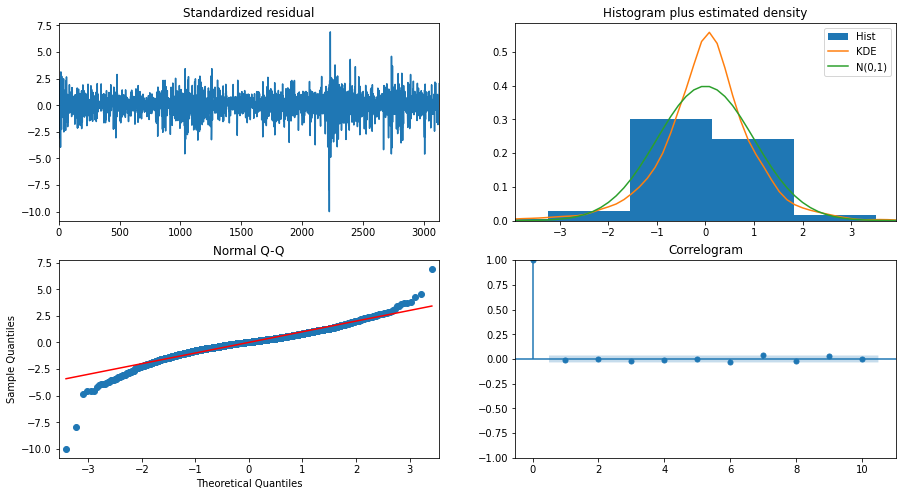

In [30]:
model_autoARIMA = auto_arima(train_data_arima, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [70]:
import statsmodels.api as sm
model = ARIMA(train_data_arima, order=(2,0,1))  
fitted = model.fit()  
print(fitted.summary())

C:\anaconda_installed\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\anaconda_installed\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3129
Model:                 ARIMA(2, 0, 1)   Log Likelihood                2850.599
Date:                Thu, 11 Jan 2024   AIC                          -5691.197
Time:                        11:05:02   BIC                          -5660.955
Sample:                             0   HQIC                         -5680.343
                               - 3129                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0117      0.429     -0.027      0.978      -0.852       0.829
ar.L1          0.0905      0.044      2.039      0.041       0.004       0.177
ar.L2          0.9023      0.044     20.402      0.0

In [71]:
# Forecast
y_check_pred_arima = fitted.forecast(window, alpha=0.05)  # 95% conf

C:\anaconda_installed\lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [72]:
mae_check_arima = mean_absolute_error(y_check* target_stdev + target_mean,y_check_pred_arima* target_stdev + target_mean)
print('Mean absolute error(check) : ',mae_check_arima)
rmse_check_arima = mean_squared_error(y_check* target_stdev + target_mean,y_check_pred_arima* target_stdev + target_mean, squared=False)
print('Root Mean Squared error(check) : ',rmse_check_arima)

Mean absolute error(check) :  22.75176847388793
Root Mean Squared error(check) :  29.2383270172977


## Data processing for regression model

In [31]:
# Data for regression model
sequence_length_reg = window_reg =10 # Number of time steps that will be inputted into LSTM network

def create_dataset_reg(dataset,target,features, lookback, window):
    X_store, y_store = [], []
    for i in range(len(dataset)-lookback-window):
        X = (dataset[features].values)[i:i+lookback]
        y = (dataset[target].values)[i+lookback-1:i+lookback+window-1]
        X_store.append(X)
        y_store.append(y)
    return X_store,y_store

X_reg,y_reg = create_dataset_reg(
    df,
    target=target,
    features=features,
    lookback=sequence_length_reg, window=window_reg)

print(np.array(X_reg).shape, np.array(y_reg).shape)

(3119, 10, 24) (3119, 10)


In [32]:
X_reg = tf.gather(X_reg, shuffled_indices)
y_reg = tf.gather(y_reg, shuffled_indices)

In [33]:
# Train test split
m=np.array(X_reg).shape[0] # get first dimension
size=int(m*0.9)
X_train_reg=X_reg[:size]
y_train_reg=y_reg[:size]
X_test_reg=X_reg[size:]
y_test_reg=y_reg[size:]
print('Shape of train is',np.array(X_train_reg).shape,'and',np.array(y_train_reg).shape)
print('Shape os test is',np.array(X_test_reg).shape,'and',np.array(y_test_reg).shape)

Shape of train is (2807, 10, 24) and (2807, 10)
Shape os test is (312, 10, 24) and (312, 10)


In [34]:
X_train_reg_=np.array([inner for outer in X_train_reg for inner in outer])
print(X_train_reg_.shape)
y_train_reg_=np.array([inner for outer in y_train_reg for inner in outer])
print(y_train_reg_.shape)

(28070, 24)
(28070,)


In [35]:
X_test_reg_=np.array([inner for outer in X_test_reg for inner in outer])
print(X_test_reg_.shape)
y_test_reg_=np.array([inner for outer in y_test_reg for inner in outer])
print(y_test_reg_.shape)

(3120, 24)
(3120,)


In [36]:
# Prepare test data
X_check_reg=(df[features].values)[len(df)-window_reg-sequence_length_reg+1:len(df)- window_reg+1]
y_check_reg=(df[target].values)[len(df)-window_reg:len(df)]

## Linear regression model

In [37]:
from sklearn.linear_model import LinearRegression
#Creating the Regressor
regressor = LinearRegression()
regressor.fit(X_train_reg_, y_train_reg_)

LinearRegression()

In [38]:
y_train_pred_mlr=regressor.predict(X_train_reg_)
mae_train_mlr = mean_absolute_error(y_train_reg_* target_stdev + target_mean,y_train_pred_mlr* target_stdev + target_mean)
print('MAE train Error : ',mae_train_mlr)
rmse_train_mlr = mean_squared_error(y_train_reg_* target_stdev + target_mean,y_train_pred_mlr* target_stdev + target_mean, squared=False)
print('RMSE train Error : ',rmse_train_mlr)

MAE train Error :  118.20555995947178
RMSE train Error :  165.4362281477088


In [39]:
y_test_pred_mlr=regressor.predict(X_test_reg_)
mae_test_mlr = mean_absolute_error(y_test_reg_* target_stdev + target_mean,y_test_pred_mlr* target_stdev + target_mean)
print('MAE test Error : ',mae_test_mlr)
rmse_test_mlr = mean_squared_error(y_test_reg_* target_stdev + target_mean,y_test_pred_mlr* target_stdev + target_mean, squared=False)
print('RMSE test Error : ',rmse_test_mlr)

MAE test Error :  118.87821243238109
RMSE test Error :  176.1853758673319


In [40]:
y_check_pred_mlr = regressor.predict(X_check_reg)
mae_check_mlr = mean_absolute_error(y_check_reg* target_stdev + target_mean,y_check_pred_mlr* target_stdev + target_mean)
print('MAE check error : ',mae_check_mlr)
rmse_check_mlr = mean_squared_error(y_check_reg* target_stdev + target_mean,y_check_pred_mlr* target_stdev + target_mean, squared=False)
print('RMSE check error: ',rmse_check_mlr)

MAE check error :  349.6513205342826
RMSE check error:  351.7809343909762


## XGboost

In [41]:
import xgboost as xg

In [42]:
# Instantiation 
xgb_r = xg.XGBRegressor(objective ='reg:squarederror', 
                   seed = 42) 
# Fitting the model 
xgb_r.fit(X_train_reg_, y_train_reg_) 

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [43]:
# Predict the model 
y_train_pred_xg = xgb_r.predict(X_train_reg_) 
mae_train_xg = mean_absolute_error(y_train_reg_* target_stdev + target_mean, y_train_pred_xg* target_stdev + target_mean)
print('MAE train : ',mae_train_xg)
rmse_train_xg = mean_squared_error(y_train_reg_* target_stdev + target_mean, y_train_pred_xg* target_stdev + target_mean, squared=False)
print('RMSE train : ',rmse_train_xg)

MAE train :  12.981215077540528
RMSE train :  16.89391452781247


In [44]:
# Predict the model 
y_test_pred_xg = xgb_r.predict(X_test_reg_) 
mae_test_xg = mean_absolute_error(y_test_reg_* target_stdev + target_mean, y_test_pred_xg* target_stdev + target_mean)
print('MAE test : ',mae_test_xg)
rmse_test_xg = mean_squared_error(y_test_reg_* target_stdev + target_mean, y_test_pred_xg* target_stdev + target_mean, squared=False)
print('RMSE test : ',rmse_test_xg)

MAE test :  14.160013271233975
RMSE test :  18.59289354978675


In [45]:
# Predict the model 
y_check_pred_xg = xgb_r.predict(X_check_reg) 
mae_check_xg = mean_absolute_error(y_check_reg* target_stdev + target_mean, y_check_pred_xg* target_stdev + target_mean)
print('Mean absolute Error : ',mae_check_xg)
rmse_check_xg = mean_squared_error(y_check_reg* target_stdev + target_mean, y_check_pred_xg* target_stdev + target_mean, squared=False)
print('Root Mean Squared Error : ',rmse_check_xg)

Mean absolute Error :  106.45943359374978
Root Mean Squared Error :  206.66926827629123


## ANN

In [48]:
from tensorflow.keras import regularizers, initializers
from keras.layers import Input, Dense, Reshape, Embedding, concatenate, Dropout, Flatten
from keras.layers.merge import Dot
from keras.preprocessing import sequence
from keras import Model

In [54]:
input_ = Input((len(features)),) # feature

den1=Dense(256, use_bias=True,activation='relu')(input_)

den2=Dense(128, use_bias=True,activation='relu')(den1)

den3=Dense(64, use_bias=True,activation='relu')(den2)

den4=Dense(32, use_bias=True,activation='relu')(den3)

den5=Dense(1, use_bias=True,activation='linear')(den4)

model = Model(inputs=[input_], outputs=den5)

In [55]:
import tensorflow as tf

In [56]:
loss_fn = tf.keras.losses.MeanSquaredError()
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(opt, loss=loss_fn)

In [57]:
model_history = model.fit(X_train_reg_, y_train_reg_,
                    validation_data=(X_test_reg_, y_test_reg_),
                   batch_size=16, 
                   epochs=150,  # total epoch
                   )

Epoch 1/150
1755/1755 [==============================] - 4s 2ms/step - loss: 0.0617 - val_loss: 0.0333
Epoch 2/150
1755/1755 [==============================] - 4s 2ms/step - loss: 0.0293 - val_loss: 0.0226
Epoch 3/150
1755/1755 [==============================] - 4s 2ms/step - loss: 0.0210 - val_loss: 0.0187
Epoch 4/150
1755/1755 [==============================] - 4s 2ms/step - loss: 0.0160 - val_loss: 0.0137
Epoch 5/150
1755/1755 [==============================] - 3s 2ms/step - loss: 0.0127 - val_loss: 0.0100
Epoch 6/150
1755/1755 [==============================] - 3s 2ms/step - loss: 0.0103 - val_loss: 0.0092
Epoch 7/150
1755/1755 [==============================] - 3s 2ms/step - loss: 0.0089 - val_loss: 0.0087
Epoch 8/150
1755/1755 [==============================] - 3s 2ms/step - loss: 0.0078 - val_loss: 0.0075
Epoch 9/150
1755/1755 [==============================] - 4s 2ms/step - loss: 0.0069 - val_loss: 0.0083
Epoch 10/150
1755/1755 [==============================] - 5s 3ms/step - l

1755/1755 [==============================] - 4s 2ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 80/150
1755/1755 [==============================] - 4s 2ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 81/150
1755/1755 [==============================] - 4s 2ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 82/150
1755/1755 [==============================] - 4s 2ms/step - loss: 0.0011 - val_loss: 9.3695e-04
Epoch 83/150
1755/1755 [==============================] - 3s 2ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 84/150
1755/1755 [==============================] - 4s 2ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 85/150
1755/1755 [==============================] - 4s 2ms/step - loss: 0.0011 - val_loss: 9.5316e-04
Epoch 86/150
1755/1755 [==============================] - 4s 2ms/step - loss: 0.0011 - val_loss: 8.4508e-04
Epoch 87/150
1755/1755 [==============================] - 4s 2ms/step - loss: 0.0011 - val_loss: 8.5975e-04
Epoch 88/150
1755/1755 [==============================] - 3s 

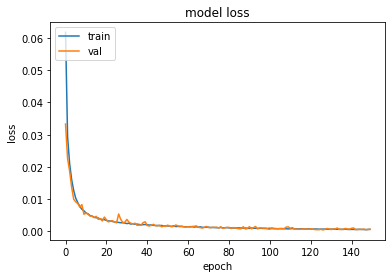

In [58]:
import keras
from matplotlib import pyplot as plt
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [59]:
# Predict the model 
y_train_pred_ann = model.predict(X_train_reg_) 
mae_train_ann = mean_absolute_error(y_train_reg_* target_stdev + target_mean, y_train_pred_ann* target_stdev + target_mean)
print('MAE train: ',mae_train_ann)
rmse_train_ann = mean_squared_error(y_train_reg_* target_stdev + target_mean, y_train_pred_ann* target_stdev + target_mean, squared=False)
print('RMSE train: ',rmse_train_ann)

MAE train:  12.790140531762109
RMSE train:  17.49350280679969


In [60]:
# Predict the model 
y_test_pred_ann = model.predict(X_test_reg_) 
mae_test_ann = mean_absolute_error(y_test_reg_* target_stdev + target_mean, y_test_pred_ann* target_stdev + target_mean)
print('MAE test: ',mae_test_ann)
rmse_test_ann = mean_squared_error(y_test_reg_* target_stdev + target_mean, y_test_pred_ann* target_stdev + target_mean, squared=False)
print('RMSE test: ',rmse_test_ann)

MAE test:  12.955870330028036
RMSE test:  17.73478198090599


In [61]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 24)]              0         
                                                                 
 dense_5 (Dense)             (None, 256)               6400      
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 49,665
Trainable params: 49,665
Non-trainable

In [62]:
y_check_pred_nn = model.predict(X_check_reg)
y_check_pred_nn=y_check_pred_nn.flatten()
mae_check_nn = mean_absolute_error(y_check_reg* target_stdev + target_mean, y_check_pred_nn* target_stdev + target_mean)
print('Mean absolute Error : ',mae_check_nn)
rmse_check_nn = mean_squared_error(y_check_reg* target_stdev + target_mean, y_check_pred_nn* target_stdev + target_mean, squared=False)
print('Root Mean Squared Error : ',rmse_check_nn)

Mean absolute Error :  32.11800781250004
Root Mean Squared Error :  50.908359159104165


In [65]:
# import module
from tabulate import tabulate
 
# assign data
mydata = [
    ["LSTM", mae_train_lstm,mae_test_lstm, rmse_train_lstm,rmse_test_lstm], 
    ["Multiple linear regression",mae_train_mlr,mae_test_mlr, rmse_train_mlr,rmse_test_mlr], 
      ["XGboost", mae_train_xg, mae_test_xg, rmse_train_xg,rmse_test_xg],
    ["ANN", mae_train_ann, mae_test_ann,  rmse_train_ann ,rmse_test_ann]
]
 
# create header
head = ["Model","Train MAE" ,"Test MAE", "Train RMSE","Test RMSE"]
# display table
print(tabulate(mydata, headers=head, tablefmt="grid"))

+----------------------------+-------------+------------+--------------+-------------+
| Model                      |   Train MAE |   Test MAE |   Train RMSE |   Test RMSE |
+============================+=============+============+==============+=============+
| LSTM                       |     9.57182 |    18.1612 |      15.3835 |     34.0568 |
+----------------------------+-------------+------------+--------------+-------------+
| Multiple linear regression |   118.206   |   118.878  |     165.436  |    176.185  |
+----------------------------+-------------+------------+--------------+-------------+
| XGboost                    |    12.9812  |    14.16   |      16.8939 |     18.5929 |
+----------------------------+-------------+------------+--------------+-------------+
| ANN                        |    12.7901  |    12.9559 |      17.4935 |     17.7348 |
+----------------------------+-------------+------------+--------------+-------------+


## Comparison

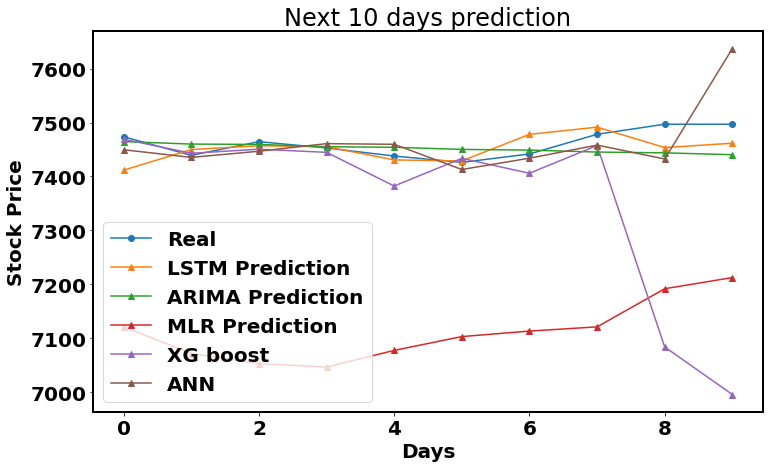

In [73]:
plt.figure(figsize=(12, 7))
# plt.plot(y_test_reg* target_stdev + target_mean, label = "Real",marker='o')
plt.plot(y_check* target_stdev + target_mean, label = "Real",marker='o')
plt.plot(y_check_pred_lstm* target_stdev + target_mean, label = "LSTM Prediction",marker='^')
plt.plot(y_check_pred_arima* target_stdev + target_mean, label = "ARIMA Prediction",marker='^')
plt.plot(y_check_pred_mlr* target_stdev + target_mean, label = "MLR Prediction",marker='^')
plt.plot(y_check_pred_xg* target_stdev + target_mean, label = "XG boost",marker='^')
plt.plot(y_check_pred_nn* target_stdev + target_mean, label = "ANN",marker='^')
plt.ylabel('Stock Price')
plt.xlabel('Days')
plt.title('Next '+str(window)+' days prediction')
plt.legend()
plt.show()

In [74]:
# import module
from tabulate import tabulate
 
# assign data
mydata = [
    ["LSTM", mae_check_lstm, rmse_check_lstm], 
    ["ARIMA", mae_check_arima, rmse_check_arima], 
    ["Multiple linear regression",mae_test_mlr, rmse_check_mlr], 
      ["XGboost", mae_check_xg, rmse_check_xg],
    ["ANN", mae_check_nn, rmse_check_nn]
]
 
# create header
head = ["Model","Check MAE" , "Check RMSE"]
# display table
print(tabulate(mydata, headers=head, tablefmt="grid"))

+----------------------------+-------------+--------------+
| Model                      |   Check MAE |   Check RMSE |
+============================+=============+==============+
| LSTM                       |     22.0733 |      29.4987 |
+----------------------------+-------------+--------------+
| ARIMA                      |     22.7518 |      29.2383 |
+----------------------------+-------------+--------------+
| Multiple linear regression |    118.878  |     351.781  |
+----------------------------+-------------+--------------+
| XGboost                    |    106.459  |     206.669  |
+----------------------------+-------------+--------------+
| ANN                        |     32.118  |      50.9084 |
+----------------------------+-------------+--------------+


In [75]:
low_=0
high_=window

In [76]:
list_real=list(y_check* target_stdev + target_mean)[low_:high_]
list_real_=list(y_check_reg* target_stdev + target_mean)[low_:high_]
list_lstm=list(y_check_pred_lstm* target_stdev + target_mean)[low_:high_]
list_arima=list(y_check_pred_arima* target_stdev + target_mean)[low_:high_]
list_mlr=list(y_check_pred_mlr* target_stdev + target_mean)[low_:high_]
list_xg=list(y_check_pred_xg* target_stdev + target_mean)[low_:high_]
list_nn=list(y_check_pred_nn* target_stdev + target_mean)[low_:high_]

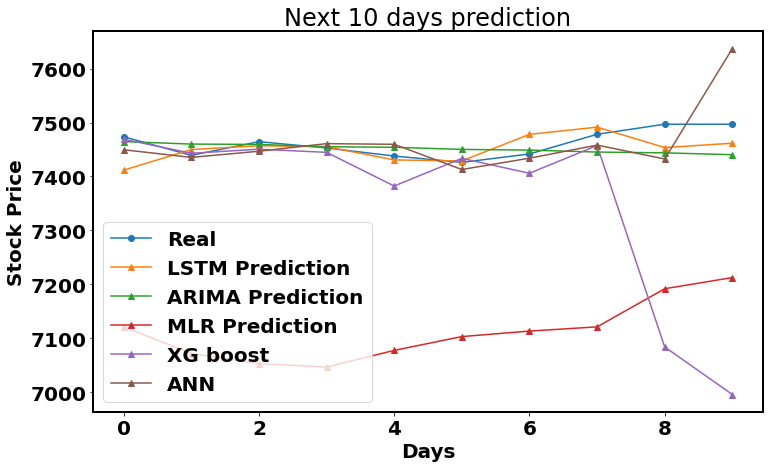

In [77]:
plt.figure(figsize=(12, 7))
plt.plot(list_real_, label = "Real",marker='o')
# plt.plot(list_real, label = "Real",marker='o')
plt.plot(list_lstm, label = "LSTM Prediction",marker='^')
plt.plot(list_arima, label = "ARIMA Prediction",marker='^')
plt.plot(list_mlr, label = "MLR Prediction",marker='^')
plt.plot(list_xg, label = "XG boost",marker='^')
plt.plot(list_nn, label = "ANN",marker='^')
plt.ylabel('Stock Price')
plt.xlabel('Days')
plt.title('Next '+str(window)+' days prediction')
plt.legend()
plt.show()

In [78]:
save_data=[list_real,list_lstm,
          list_arima,list_mlr,
          list_xg,list_nn]

In [79]:
import csv 
# name of csv file   
filename = "Stock Prediction_predict_3_ver_2_DRC.csv"
      
# writing to csv file   
with open(filename, 'w') as csvfile:   
    # creating a csv writer object   
    csvwriter = csv.writer(csvfile)     
          
    # writing the data rows   
    csvwriter.writerows(save_data)

In [80]:
mae_check_lstm = mean_absolute_error(list_real,list_lstm)
print('Mean absolute Error : ',mae_check_lstm)
rmse_check_lstm = mean_squared_error(list_real,list_lstm, squared=False)
print('Root Mean Squared Error : ',rmse_check_lstm)

Mean absolute Error :  22.073339843749817
Root Mean Squared Error :  29.498719661310094


In [81]:
mae_check_arima = mean_absolute_error(list_real,list_arima)
print('Mean absolute Error : ',mae_check_arima)
rmse_check_arima = mean_squared_error(list_real,list_arima, squared=False)
print('Root Mean Squared Error : ',rmse_check_arima)

Mean absolute Error :  22.75176847388793
Root Mean Squared Error :  29.2383270172977


In [82]:
mae_check_mlr = mean_absolute_error(list_real,list_mlr)
print('Mean absolute Error : ',mae_check_mlr)
rmse_check_mlr = mean_squared_error(list_real,list_mlr, squared=False)
print('Root Mean Squared Error : ',rmse_check_mlr)

Mean absolute Error :  349.6513205342826
Root Mean Squared Error :  351.7809343909762


In [83]:
mae_check_xg = mean_absolute_error(list_real,list_xg)
print('Mean absolute Error : ',mae_check_xg)
rmse_check_xg = mean_squared_error(list_real, list_xg, squared=False)
print('Root Mean Squared Error : ',rmse_check_xg)

Mean absolute Error :  106.45943359374978
Root Mean Squared Error :  206.66926827629123


In [84]:
mae_check_nn = mean_absolute_error(list_real,list_nn)
print('Mean absolute Error : ',mae_check_nn)
rmse_check_nn = mean_squared_error(list_real, list_nn, squared=False)
print('Root Mean Squared Error : ',rmse_check_nn)

Mean absolute Error :  32.11800781250004
Root Mean Squared Error :  50.908359159104165


In [85]:
# import module
from tabulate import tabulate
 
# assign data
mydata = [
    ["LSTM", mae_check_lstm, rmse_check_lstm], 
    ["ARIMA", mae_check_arima, rmse_check_arima], 
    ["Multiple linear regression",mae_test_mlr, rmse_check_mlr], 
      ["XGboost", mae_check_xg, rmse_check_xg],
    ["ANN", mae_check_nn, rmse_check_nn]
]
 
# create header
head = ["Model","Test MAE" , "Test RMSE"]
# display table
print(tabulate(mydata, headers=head, tablefmt="grid"))

+----------------------------+------------+-------------+
| Model                      |   Test MAE |   Test RMSE |
+============================+============+=============+
| LSTM                       |    22.0733 |     29.4987 |
+----------------------------+------------+-------------+
| ARIMA                      |    22.7518 |     29.2383 |
+----------------------------+------------+-------------+
| Multiple linear regression |   118.878  |    351.781  |
+----------------------------+------------+-------------+
| XGboost                    |   106.459  |    206.669  |
+----------------------------+------------+-------------+
| ANN                        |    32.118  |     50.9084 |
+----------------------------+------------+-------------+


In [86]:
df_=pd.read_csv('Stock Prediction_predict_3_ver_2_DRC.csv',header=None)  

In [87]:
result_real=df_.iloc[0,:].values
result_lstm=df_.iloc[1,:].values
result_arima=df_.iloc[2,:].values
result_mlr=df_.iloc[3,:].values
result_xg=df_.iloc[4,:].values
result_nn=df_.iloc[5,:].values

In [88]:
from sklearn.metrics import r2_score
print ('R2 score between real and lstm',r2_score(result_real, result_lstm))
print ('R2 score between real and ARIMA',r2_score(result_real, result_arima))
print ('R2 score between real and MLR',r2_score(result_real, result_mlr))
print ('R2 score between real and xg',r2_score(result_real, result_xg))
print ('R2 score between real and nn',r2_score(result_real, result_nn))

R2 score between real and lstm -0.521954388732023
R2 score between real and ARIMA -0.4952048189978462
R2 score between real and MLR -215.44135594270992
R2 score between real and xg -73.70464297145202
R2 score between real and nn -3.5328838103107847


In [89]:
def accuracy(y_true, y_pred, threshold):
    c=0
    for i in range(len(y_true)):
        if abs(y_true[i]-y_pred[i])<threshold:
            c=c+1
    return c/len(y_true)

In [90]:
threshold=100
print('The mean absolute error between real and lstm is',accuracy(result_real, result_lstm,threshold))
print('The mean absolute error between real and arima is',accuracy(result_real, result_arima,threshold))
print('The mean absolute error between real and MLR is',accuracy(result_real, result_mlr,threshold))
print('The mean absolute error between real and xg is',accuracy(result_real, result_xg,threshold))
print('The mean absolute error between real and nn is',accuracy(result_real, result_nn,threshold))

The mean absolute error between real and lstm is 1.0
The mean absolute error between real and arima is 1.0
The mean absolute error between real and MLR is 0.0
The mean absolute error between real and xg is 0.8
The mean absolute error between real and nn is 0.9
